In [27]:
import torch 
from torch import nn, optim
from torchvision import models, transforms
from PIL import Image 
import matplotlib.pyplot as plt 

In [28]:
class vgg(torch.nn.Module):

    def __init__(self):
        super(vgg,self).__init__()

        self.activation_layers = [0, 5, 10, 19, 28]
        self.model = models.vgg19(pretrained=True).features

    def forward(self,x):
        activations = []
        for layer_number, layer in enumerate(self.model):
            x = layer(x)
            if layer_number in self.activation_layers : 
                activations.append(x)

        return activations

In [29]:
def image_loader(content_path, style_path, resize_ratio=1):
    content_img = Image.open(content_path)
    h, w = content_img.size
    h, w = int(h * resize_ratio), int(w * resize_ratio)

    transform = transforms.Compose([
        transforms.Resize((w,h)),
        transforms.ToTensor(),
    ])

    content_img = transform(content_img)
    style_img = transform(Image.open(style_path))
    generated_img = content_img.clone().requires_grad_(True)

    return content_img, style_img, generated_img


def gram_matrix(arr):
    ch, h, w = arr.shape 
    arr = arr.view(ch, h * w)
    return torch.mm(arr, arr.t())


def display_output(arr):
    img = transforms.ToPILImage()(arr.clip(0,1).detach())
    img.save('data/output3.jpg')
    plt.imshow(img)

In [30]:
content_img, style_img, generated_img = image_loader('data/content.jpg', 'data/style3.jpg', 0.5) # load images

loss_network = vgg().requires_grad_(False) # vgg is not being trained, so requires_grad is turned off
mse_loss = nn.MSELoss()
content_activations, style_activations = loss_network(content_img), loss_network(style_img) 
# content and style activations are only taken in the start, since content and style images do not change, only generated does
style_grams = [gram_matrix(x) for x in style_activations]

style_layer_weights = [0.0, 0.2, 0.2, 0.2, 0.3, 0.1] # weights to adjust prominence of activation layer

opt = optim.Adam(params=[generated_img], lr=0.01)
content_weight, style_weight = 1, 1e7

for i in range(50):
    generated_activations = loss_network(generated_img)
    content_loss = style_loss = 0

    loop = zip(content_activations, style_grams, generated_activations, style_layer_weights[1:])
    for content, style_gram, generated, weight in loop:
        content_loss += mse_loss(content, generated)
        style_loss += (mse_loss(style_gram, gram_matrix(generated)) * weight)
    
    style_loss += (mse_loss(gram_matrix(generated_img), gram_matrix(style_img)) * style_layer_weights[0])
    
    total_loss = (content_loss * content_weight) + (style_loss * style_weight)
    print(f'{i} : {total_loss.item()}')

    opt.zero_grad()
    total_loss.backward()
    opt.step()

0 : 637347578249216.0
1 : 592063389237248.0
2 : 528603871707136.0
3 : 460138402021376.0
4 : 395887234777088.0
5 : 339308489736192.0
6 : 292061064462336.0
7 : 253418438393856.0
8 : 221220796628992.0
9 : 193239755784192.0
10 : 168482322776064.0
11 : 146752908820480.0
12 : 128370281021440.0
13 : 113196832653312.0
14 : 100820062306304.0
15 : 90859747934208.0
16 : 82826053550080.0
17 : 76275859324928.0
18 : 70843606499328.0
19 : 66248528363520.0
20 : 62276853825536.0
21 : 58779295023104.0
22 : 55646900715520.0
23 : 52813816135680.0
24 : 50231131504640.0
25 : 47837547069440.0
26 : 45602004008960.0
27 : 43502566113280.0
28 : 41529263521792.0
29 : 39671618863104.0
30 : 37924603166720.0
31 : 36281992085504.0
32 : 34736068100096.0
33 : 33282794192896.0
34 : 31909717475328.0
35 : 30617179783168.0
36 : 29404877029376.0
37 : 28271710306304.0
38 : 27212375916544.0
39 : 26222421606400.0
40 : 25294029193216.0
41 : 24423365083136.0
42 : 23608906743808.0
43 : 22846032052224.0
44 : 22127317090304.0
45 : 

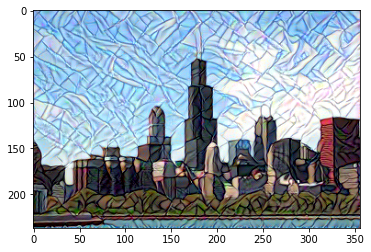

In [31]:
display_output(generated_img)